# Unsupervised Learning and Facial Recognition

# Face Recognition

The goal for this project is to explore the basics of a face recognition system.

# Part 1: Data Preprocessing and Exploration

We will use "Faces in the Wild" data set.

### 1.1 Filter out people with few images

First, display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images from your dataset? 

Now, remove all individuals for whom you have fewer than 10 images. How many individuals are you left with in the dataset?

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from skimage.color import rgb2gray
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
# Folder name
file_ds =  "lfw_funneled"

# Dictionary to store image count per folder
all_images = {}

# List to store all image paths
imgs = []

# Loop through each folder in the dataset
for folder in os.listdir(file_ds):
    # Get the directory for each folder
    folder_path = os.path.join(file_ds, folder)
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        # Counter
        counts = 0
        # Loop through each image in the current folder
        for image in os.listdir(folder_path):
            # Get path for each image
            image_path = os.path.join(folder_path, image)
            # Count number of images
            counts += 1
            # Add to the list of images
            with Image.open(image_path) as img:
                imgs.append(img.copy())
        # Add the folder name and counts to the dictionary
        all_images[folder] = counts

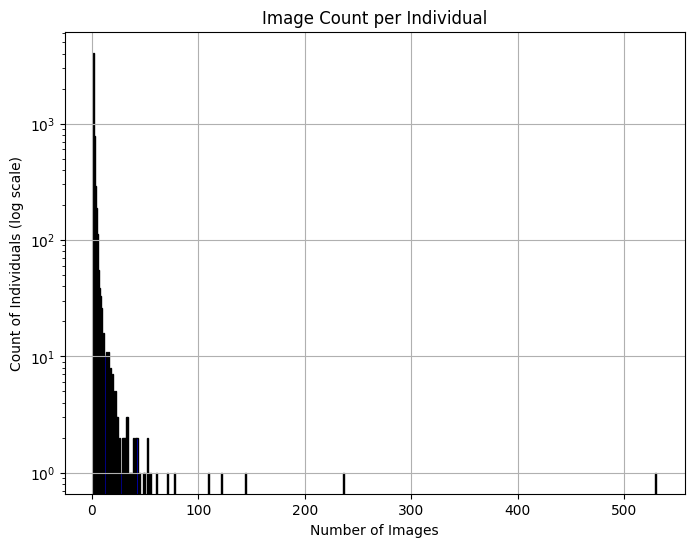

In [3]:
# Plot histogram in log-scale
plt.figure(figsize=(8, 6))
plt.hist(all_images.values(), bins=range(1, max(all_images.values()) + 1), log=True, color='blue', edgecolor='black')
plt.title('Image Count per Individual')
plt.xlabel('Number of Images')
plt.ylabel('Count of Individuals (log scale)')
plt.grid(True)
plt.show()

In [4]:
# Find individual with the most images
for key, value in all_images.items():
    if value == max(all_images.values()):
        print(f"The individual with the most images is {key}: {value} images")

The individual with the most images is George_W_Bush: 530 images


In [5]:
# Remove individuals with less than 10 images
images_over10 = {key:values for key, values in all_images.items() if values >= 10}
print(f"Number of individuals with more than 10 images: {len(images_over10)}")

Number of individuals with more than 10 images: 158


The individual with the most images in the dataset is George W. Bush, who has 530 images. After filtering out individuals with fewer than 10 images, 158 individuals remain in the dataset.

### 1.2 Show some faces!

1. Pick 10 random images from the dataset and display them in a 2 x 5 grid.
2. This time pick 200 random images. Create a single image that shows the "average face" over this random sample -- i.e. each pixel should display the average value of that particular pixel across the random sample. 

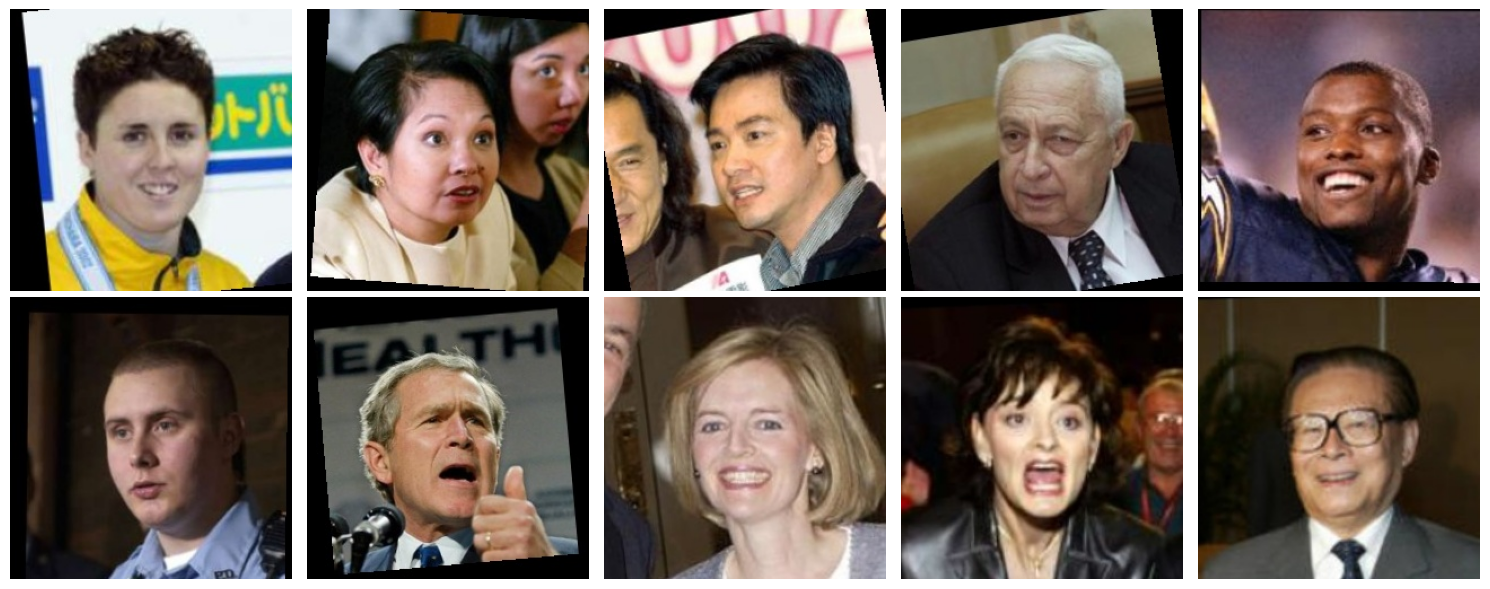

In [6]:
# Set a seed for reproducibility
np.random.seed(500)

# Select the index for 10 random images
random_10_imgs = np.random.choice(len(imgs), size=10, replace=False)

# Plot 10 random images in a 2 x 5 grid
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[random_10_imgs[idx]])
    ax.axis("off")

plt.tight_layout()
plt.show()

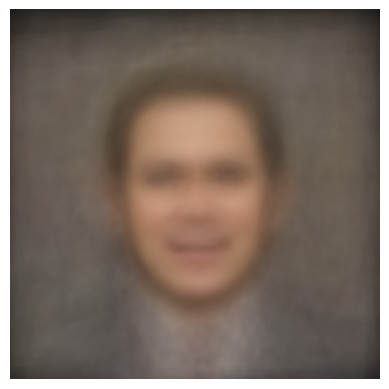

In [7]:
# Select the index for 200 random images
random_200_imgs = np.random.choice(len(imgs), size=200, replace=False)

# Convert images to numpy array
imgs_array = [np.array(imgs[i]) for i in random_200_imgs]

# Compute the average image
avg_img = np.mean(imgs_array, axis=(0))

# Convert array back to image
image = Image.fromarray(avg_img.astype(np.uint8))

# Display the average face image
plt.imshow(image)
plt.axis("off")
plt.show()

# Part 2: k-Means Clustering


### 2.1 Implementation

Implement the k-Means clustering algorithm that we discussed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

In [8]:
# Create k-means class
class KMeans:
    def __init__(self, k, max_iter):
        self.k = k
        self.max_iter = max_iter
    
    def InitializeCentroids(self, X):
        # Randomly select k indices from the dataset X
        cent_idx = np.random.choice(np.shape(X)[0], size=self.k, replace=False)
        # Initialize centroids by selecting random datapoints from X
        centroids = X[cent_idx]
        return centroids
    
    def FindClosestCentroids(self, X, centroids):
        # Find the closest centrioid to each datapoint
        closest_cent = pairwise_distances_argmin(X, centroids, metric="euclidean")
        return closest_cent
    
    def ComputeCentroidMeans(self, X, closest_cent):
        # Get the mean for each cluster
        cent_mean = np.array([np.mean(X[closest_cent == i], axis=0) for i in range(self.k)])
        return cent_mean
    
    def fit(self, X):
        # Count the number of iterations
        i = 0
        # Initialize centroid
        centroids = self.InitializeCentroids(X)
        
        # Iterate until the max iteration reached or convergence
        for i in range(self.max_iter):
            
            # Assign datapoints to the closest centroid
            closest_cent = self.FindClosestCentroids(X, centroids)
            
            # Find the mean of each cluster and make it the new centroid
            new_cent = self.ComputeCentroidMeans(X, closest_cent)
            
            # Check for convergnece
            if np.all(np.abs(centroids - new_cent) < 0.0001):
                print(f"Converged after {i} iterations")
                break

            # Update centroid
            centroids = new_cent
            i += 1
        
        return centroids, closest_cent

### 2.2 Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. Also create a scatterplot that shows these datapoints, colored by cluster. 

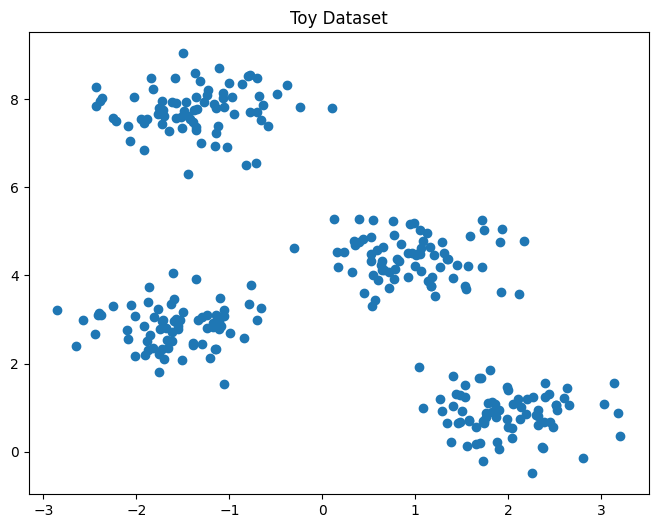

In [9]:
# Create a dataset with 4 clusters
X, Y = make_blobs(n_samples=300, centers=4, cluster_std=0.5, random_state=0)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1])
plt.title('Toy Dataset')
plt.show()

Converged after 5 iterations


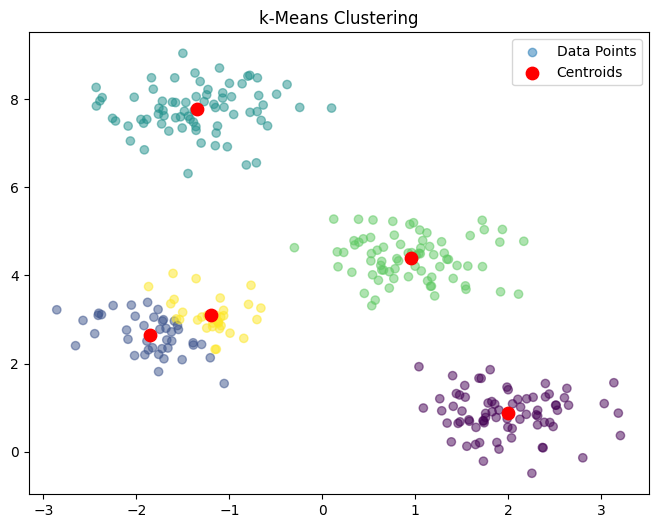

In [10]:
# Fit the kmeans model
kmeans = KMeans(5, 1000)
centroids, close_cent = kmeans.fit(X)

# Plot
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=close_cent, cmap='viridis', alpha=0.5, label='Data Points')

# plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='o', s=80, label='Centroids')
plt.title('k-Means Clustering')
plt.legend()
plt.show()

### 2.3 Image centroids
Apply your k-Means algorithm to the images dataset, using k=10. Make sure to standardize your data first! Show a 10 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250x250x3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- and even if it is -- it might take a long time for your algorithm to converge. If your computer is slow, it might even take a very long time for you to simply standardize your data. We recommend you convert your RGB images into grayscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function, or any other way to convert to graysacle) before standardizing.



In [11]:
# Convert RGB images to grayscale
imgs_gray = np.array([rgb2gray(img) for img in imgs])

# Flatten
imgs_gray_flat = imgs_gray.reshape(len(imgs_gray), -1)

In [12]:
# Standardize
scalar = StandardScaler()
imgs_std = scalar.fit_transform(imgs_gray_flat)

In [13]:
# Fit the kmeans model
kmeans = KMeans(10, 100)
centroids, close_cent = kmeans.fit(imgs_std)

Converged after 59 iterations


In [14]:
# Compute all pairwise distances between centroids and images
distances = cdist(centroids, imgs_std)

# Find the index of the minimum distance for each centroid
closest_indices = np.argmin(distances, axis=1)

# Extract the closest images
closest_img = [imgs_std[idx] for idx in closest_indices]

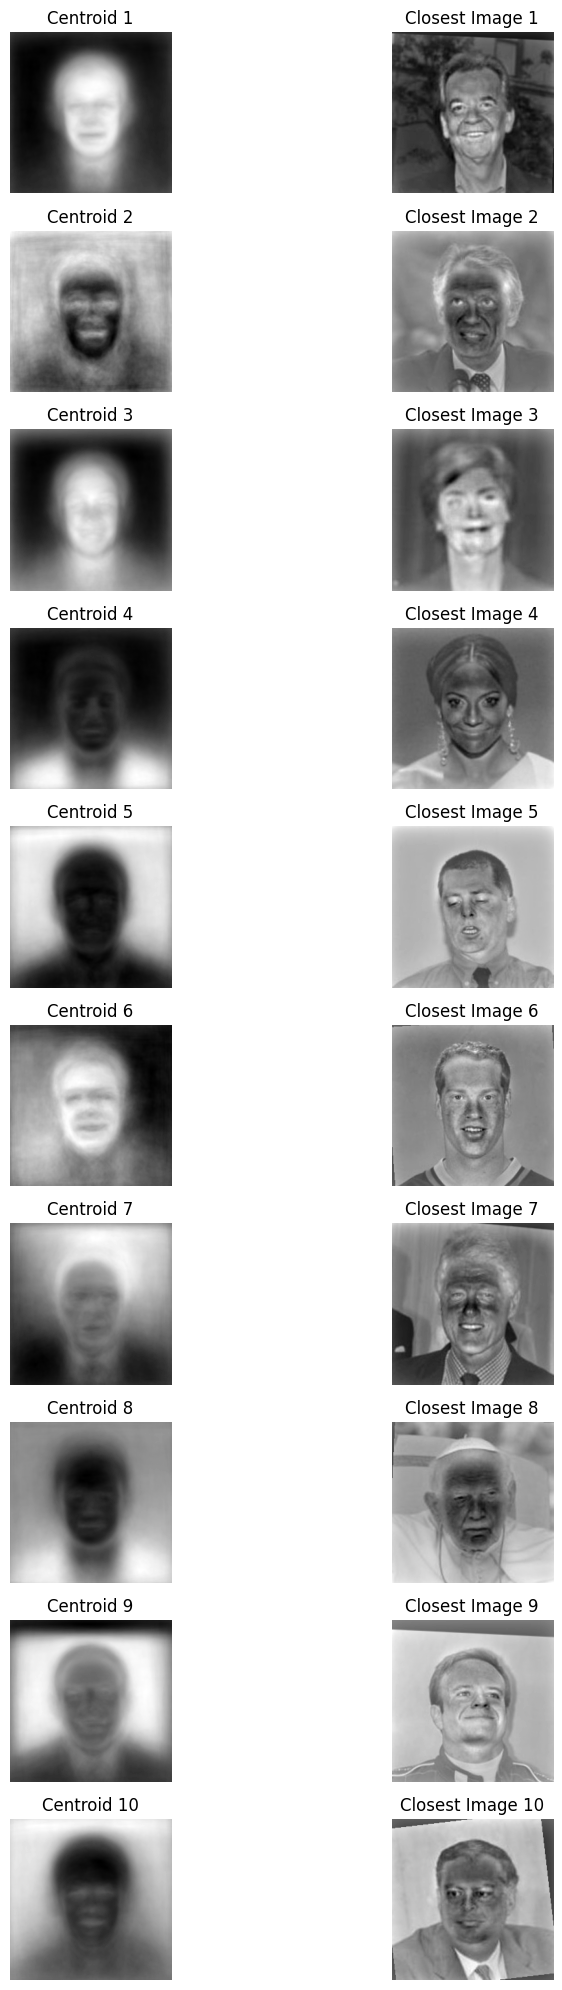

In [15]:
# Plot 10 x 2 grid of images
fig, axes = plt.subplots(10, 2, figsize=(10,20))

for i in range(10):
    # Plot centroid image
    ax = axes[i, 0]
    centroid_image = centroids[i].reshape(250, 250)
    ax.imshow(centroid_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Centroid {i+1}')

    # Plot closest image
    ax = axes[i, 1]
    ax.imshow(closest_img[i].reshape(250, 250), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Closest Image {i+1}')

plt.tight_layout()
plt.show()

The centroids are blurry which is expected since it represents the average or most common features of the images in its cluster. The shape of the closest image is somehow reflected by the centroid, and there are a few similarities in shades across different parts of the images.

The shades of the faces and the background in the centroids and its closest image are the particular similarities noticed, beyond that the exact features in the images are not exactly captured or represented.

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself.
 2. The cluster centroid closest to that image.
 3. The closest image in the dataset to that cluster centroid.
 4. The closest image in the dataset to the image of yourself.


In [16]:
# Load my image
kt_image = "kaiting.jpg"

with Image.open(kt_image) as my_img:
    #Resize image
    my_img = my_img.resize((250, 250))
    # Convert RGB images to grayscale
    my_img_gray = rgb2gray(np.array(my_img))

# Flatten
my_img_gray_flat = my_img_gray.flatten().reshape(1, -1)

# Standardize
my_img_std = scalar.transform(my_img_gray_flat)

In [17]:
# Find the closest centroid to my image
dist_my_img = np.linalg.norm(centroids - my_img_std)
closest_centroid_idx = np.argmin(dist_my_img)
closest_centroid = centroids[closest_centroid_idx]

In [18]:
# Find the closest image in the dataset to the closest centroid
dist_img = np.linalg.norm(closest_centroid - imgs_std)
closest_image_idx1 = np.argmin(dist_img)
closest_image1 = imgs_std[closest_image_idx1]

In [19]:
# Find the closest image in the dataset to my image
my_img_dist = np.linalg.norm(imgs_std - my_img_std)
closest_image_idx2 = np.argmin(my_img_dist)
closest_image2 = imgs_std[closest_image_idx2]

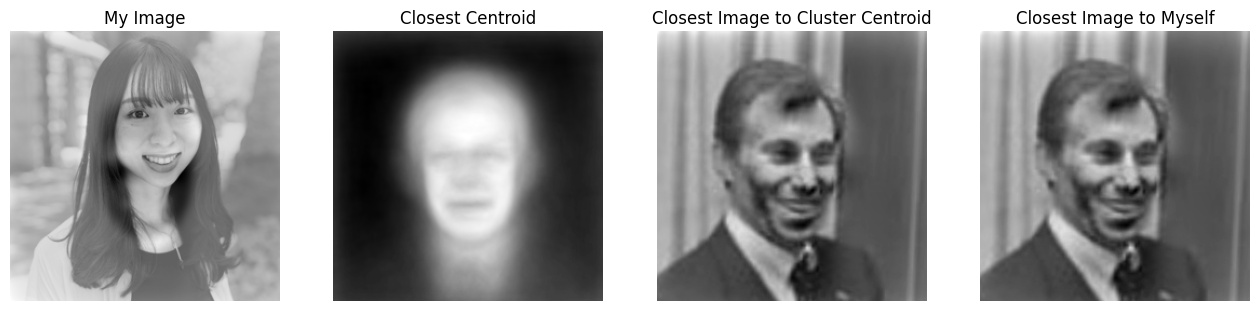

In [20]:
# Plot
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Plot my image
axs[0].imshow(my_img_std.reshape(250, 250), cmap='gray')
axs[0].set_title('My Image')
axs[0].axis('off')

# Plot the closest centroid
axs[1].imshow(closest_centroid.reshape(250, 250), cmap='gray')
axs[1].set_title('Closest Centroid')
axs[1].axis('off')

# Plot the closest image to centroid
axs[2].imshow(closest_image1.reshape(250, 250), cmap='gray')
axs[2].set_title('Closest Image to Cluster Centroid')
axs[2].axis('off')

# Plot the closest image to my image
axs[3].imshow(closest_image2.reshape(250, 250), cmap='gray')
axs[3].set_title('Closest Image to Myself')
axs[3].axis('off')

plt.show()

# Part 3: PCA and Eigenfaces 

Ensure you are using standardized data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1 How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

In [21]:
# Split data into train and test
train_X, test_X = train_test_split(imgs_std, test_size=0.5, random_state=0)

In [22]:
# Intialize pca instance
pca = PCA(100)
pca.fit(train_X)

PCA(n_components=100)

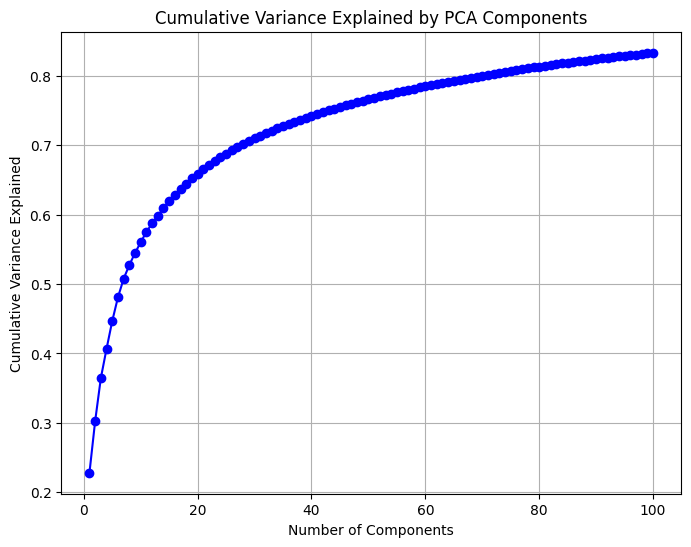

In [23]:
# Cumulative variance explained explained by the first 100 components
cum_var = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), cum_var, marker='o', linestyle='-', color='b')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

In [24]:
# Find the number of components needed to explain at least 75% of the variance
cum_var_75 = np.argmax(cum_var >= 0.75) + 1
print(f"Number of components needed to explain 75% of variance: {cum_var_75}")

Number of components needed to explain 75% of variance: 44


The number of components needed to explain 75% of variance is at least 44.

### 3.2 The Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

In [25]:
# Get the 10 first principal components 
pca = PCA(10)  
pca.fit(train_X)

PCA(n_components=10)

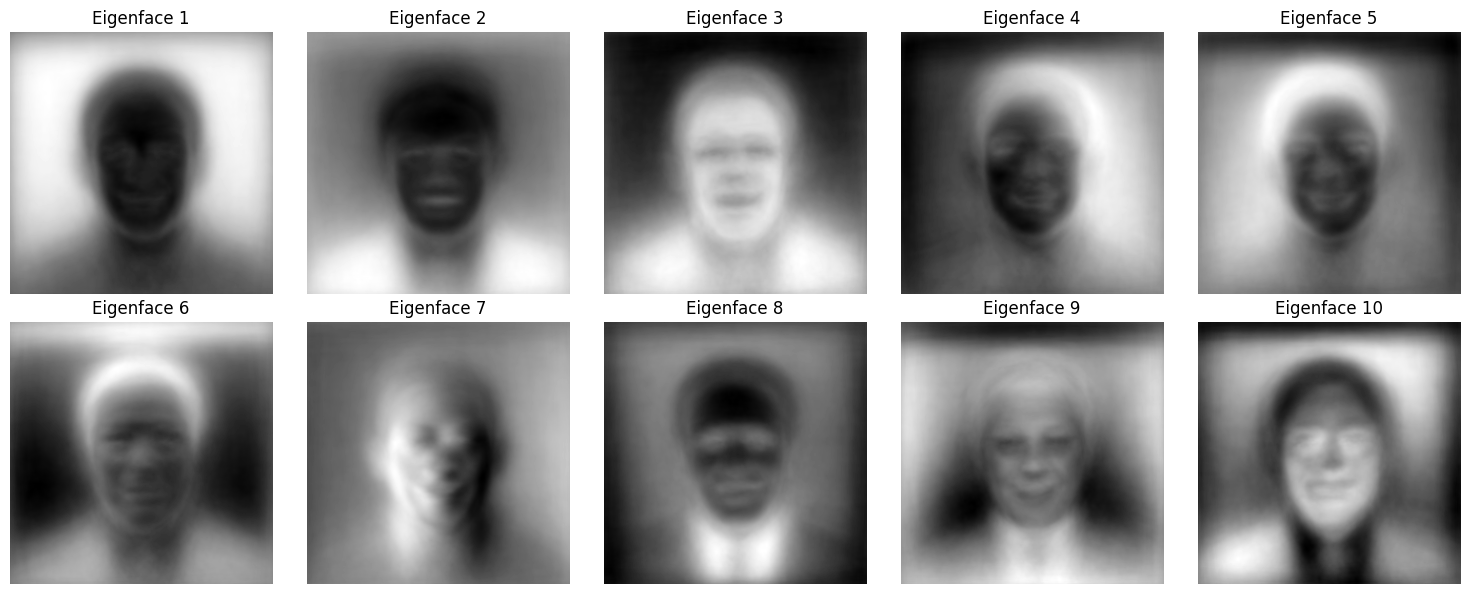

In [26]:
# Display eigenfaces
eigenfaces = pca.components_.reshape((10, 250, 250))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 3.3 Projections, clustering and PCA
 - Project all of the training and test data into the 40-dimensional space defined by the first 40 principal components.
 - Apply k-means clustering, with k=16, to the 40-dimensional projections of the training data. 
 - Display a 4 x 4 grid of images that shows what each of the 16 centroids look like after the centroid is projected back into the original-image space.

In [27]:
# Get 40 first principal components 
pca_40 = PCA(40)  
pca_40.fit(train_X)

# Project the data into the 40 dimensional PCA space
train_pca = pca_40.transform(train_X)
test_pca = pca_40.transform(test_X)

In [28]:
# Fit the k-means model to the projections of the training data
kmeans = KMeans(16, 200)
centroids_pca, close_cent_pca = kmeans.fit(train_pca)

Converged after 66 iterations


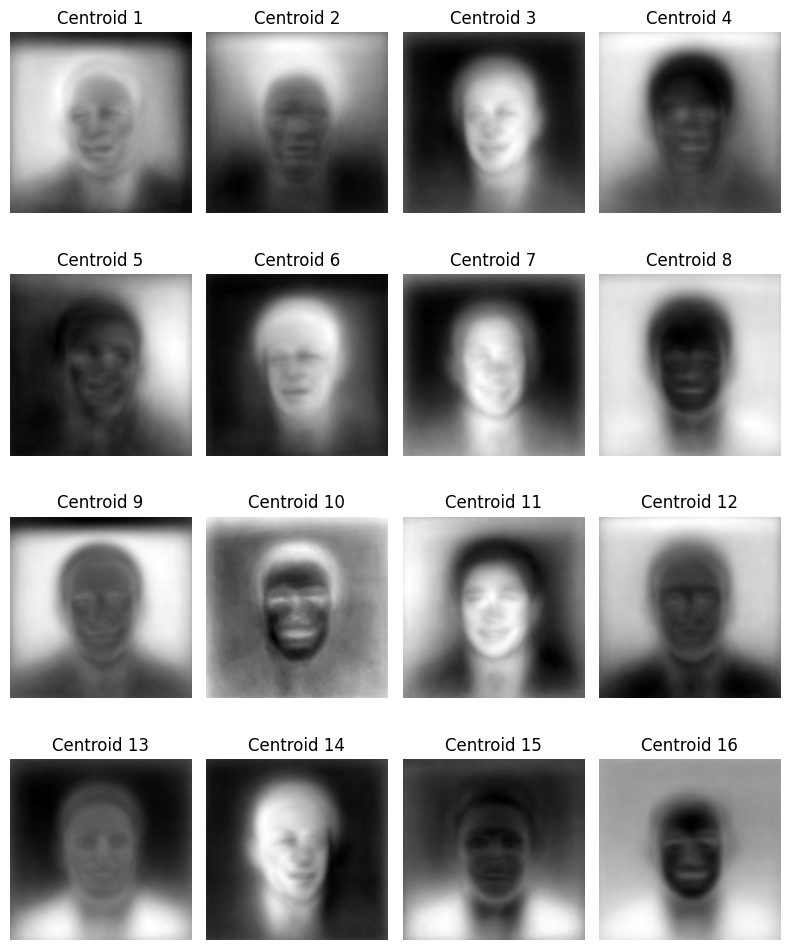

In [29]:
# Transform centroids from 40-dimensional space back to the original image space
centroids_original = pca_40.inverse_transform(centroids_pca)

# Plot centroids
fig, axes = plt.subplots(4, 4, figsize=(8, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(centroids_original.reshape(-1, 250, 250)[i], cmap='gray')
    ax.set_title(f'Centroid {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 3.4 Recognition

Create a set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 40-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 40-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

Post the five images corresponding to your headshot on piazza to share with the rest of the class.

In [30]:
# Select 8 random images from test
np.random.seed(0)
rand_8_imgs = np.random.choice(len(test_X), size=8, replace=False)
test_rand = test_X[rand_8_imgs]

In [32]:
# Non-face image
non_face = "non_face.jpg"

with Image.open(non_face) as non_face_img:
    # Resize image
    non_face_img = non_face_img.resize((250, 250))
    # Convert RGB images to grayscale
    non_face_img_gray = rgb2gray(np.array(non_face_img))

# Flatten
non_face_img_gray_flat = non_face_img_gray.flatten().reshape(1, -1)

# Standardize
non_face_img_std = scalar.transform(non_face_img_gray_flat)

In [33]:
# Combine images to create a set of 10 images
images_10 = np.vstack([test_rand, non_face_img_std, my_img_std])

# Project images into the 40 dimensional PCA space
images_10_pca = pca_40.transform(images_10)

# Transform images from 40-dimensional space back to the original feature space
images_10_original = pca_40.inverse_transform(images_10_pca)

In [34]:
# Find the nearest centroid to the images
dist_img10 = cdist(centroids_pca, images_10_pca)
closest_idx_img10 = np.argmin(dist_img10, axis=1)
closest_centroids_img10 = centroids_pca[closest_idx_img10]

# Transform nearest centroid from 40-dimensional space back to the original feature space
closest_centroids_img10_original = pca_40.inverse_transform(closest_centroids_img10)

In [35]:
# Find the closest image from the training data
dist_train = cdist(closest_centroids_img10, train_pca)
closest_idx_train = np.argmin(dist_train, axis=1)
closest_train_pca = train_pca[closest_idx_train]
closest_train_pca_original = pca_40.inverse_transform(closest_train_pca)

# Original training image
closest_train = train_X[closest_idx_train]

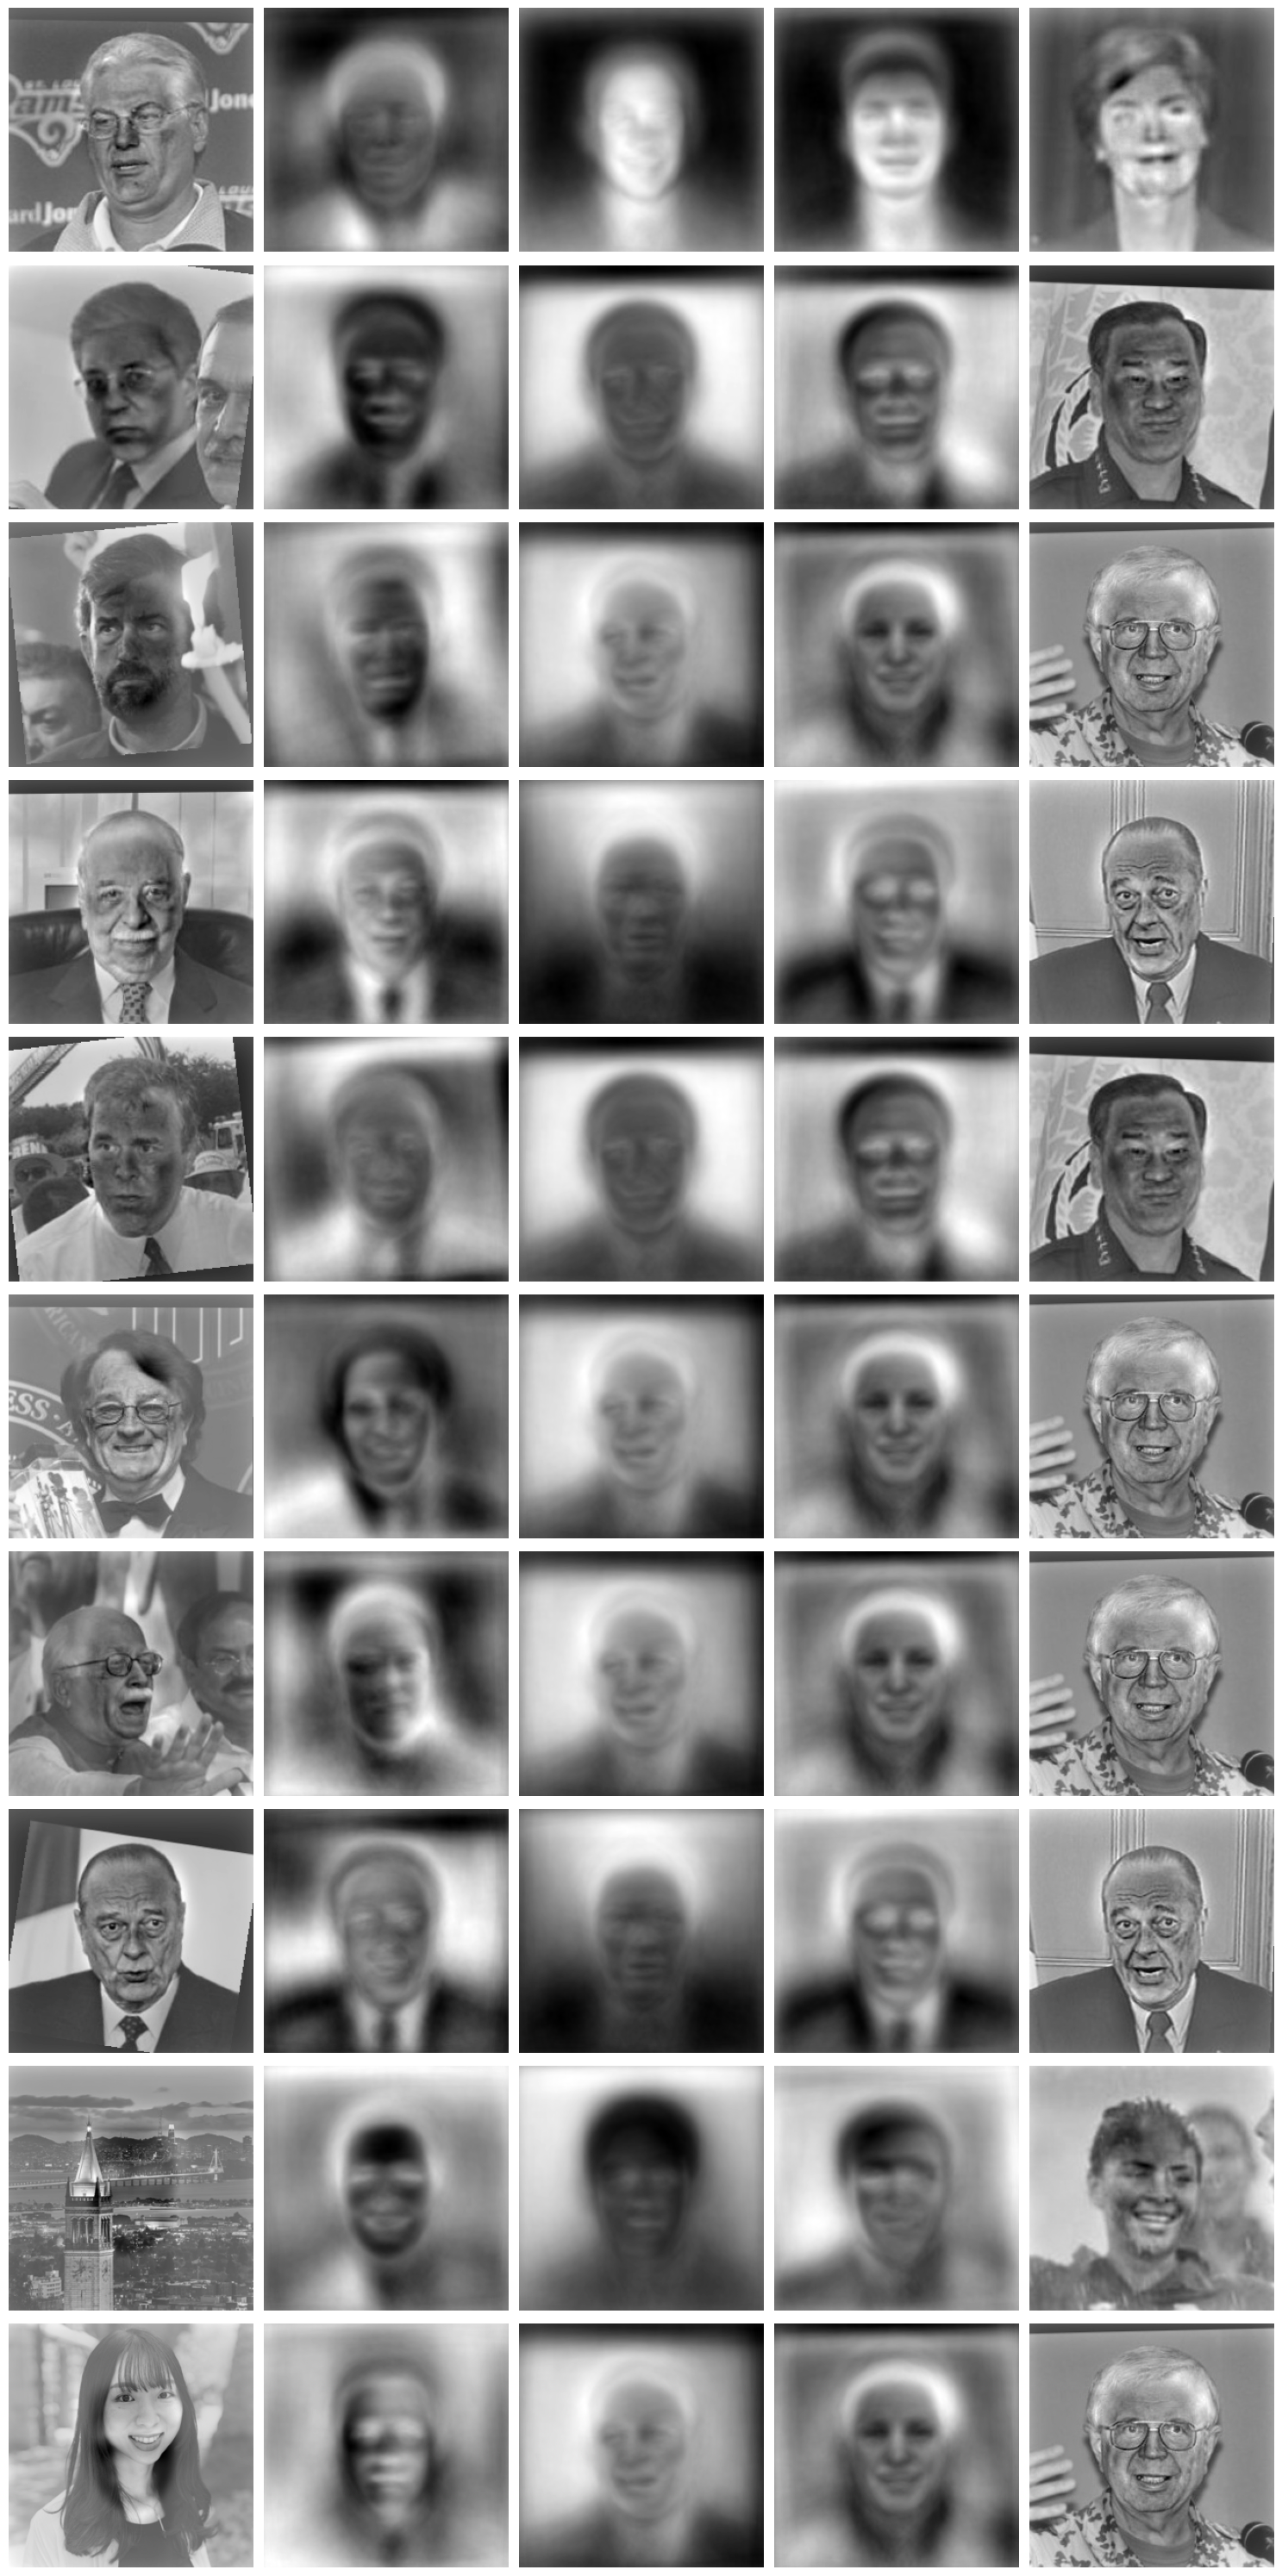

In [36]:
# Plot images
fig, axes = plt.subplots(10, 5, figsize=(15, 30))
for i in range(10):
    axes[i, 0].imshow(images_10[i].reshape(250, 250), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(images_10_original[i].reshape(250, 250), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(closest_centroids_img10_original[i].reshape(250, 250), cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 3].imshow(closest_train_pca_original[i].reshape(250, 250), cmap='gray')
    axes[i, 3].axis('off')
    axes[i, 4].imshow(closest_train[i].reshape(250, 250), cmap='gray')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

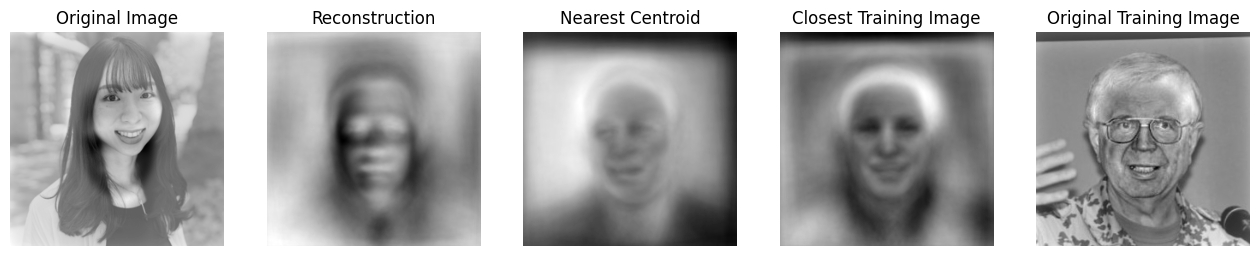

In [37]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

# Original Imag
axs[0].imshow(images_10[9].reshape(250, 250), cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

# Reconstruction
axs[1].imshow(images_10_original[9].reshape(250, 250), cmap='gray')
axs[1].set_title('Reconstruction')
axs[1].axis('off')

# Reconstructed Nearest Centroid
axs[2].imshow(closest_centroids_img10_original[9].reshape(250, 250), cmap='gray')
axs[2].set_title('Nearest Centroid')
axs[2].axis('off')

# Reconstructed Closest Training Image
axs[3].imshow(closest_train_pca_original[9].reshape(250, 250), cmap='gray')
axs[3].set_title('Closest Training Image')
axs[3].axis('off')

# Original Training Image
axs[4].imshow(closest_train[9].reshape(250, 250), cmap='gray')
axs[4].set_title('Original Training Image')
axs[4].axis('off')

plt.show()